# Project: Twitter Vaccine Sentiment Analysis  : 
 ### <b><u>Aim</u> :
 - Finding out the sentiment related to vaccine tweets from twitter
 - Performing LDA to find out the Topics related to the above tweets
 

# Importing necessary libraries

In [1]:
import numpy as np 
import pandas as pd 
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import array
import random
from PIL import Image
from plotly.subplots import make_subplots
from nltk.sentiment.vader import SentimentIntensityAnalyzer as Vader
from wordcloud import WordCloud,STOPWORDS
from nltk.util import ngrams
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import scipy.stats as stats
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob
import plotly
import plotly.offline as pyoff
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.graph_objs as go
import logging
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import json
import warnings
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Phrases
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

plt.rc('figure',figsize=(17,13))
sns.set_style('whitegrid')

In [2]:
#Helper functions

#Removes duplicate words
def dup(top_words):
    a=[]
    unq = []
    for i in top_words:
        a.append(i.split(' '))
    for l in a:
        for element in l:
            unq.append(element)
    return unq

#Creating a word cloud
def wcloud(my_list):
    word_cloud_dict=Counter(my_list)
    wordcloud_T = WordCloud(width = 600, height = 400,max_words=500,max_font_size=500,collocations = False,random_state=1,colormap = 'nipy_spectral', background_color='white',mask=mask).generate_from_frequencies(word_cloud_dict)

    plt.figure(figsize=(11,8))
    plt.imshow(wordcloud_T)
    plt.axis("off")
    return plt.show()

#Creating top n number of words per Topic
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

#Computing Coherence Value
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
   
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

#Prepossing the text
def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    
    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 3] for doc in docs]
    
    # Lemmatize all words in documents.
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
  
    return docs

#Creating Topic matrix
def get_keys(topic_matrix):
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

#Creating word counts
def keys_to_counts(keys):
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)


# Importing file

In [3]:
data = pd.read_csv('vaccination_tweets.csv')
data.text =data.text.str.lower()
data.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,while the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #sputnikv #astrazeneca #pfizerbio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"facts are immutable, senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,explain to me again why we need a vaccine @bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


## Cleaning the data

In [4]:
#Removing twitter handlers
data.text = data.text.apply(lambda x:re.sub('@[^\s]+','',x))

#Removing hashtags
data.text = data.text.apply(lambda x:re.sub(r'\B#\S+','',x))

#Removing URLS
data.text = data.text.apply(lambda x:re.sub(r"http\S+", "", x))

#Removing special characters
data.text = data.text.apply(lambda x:' '.join(re.findall(r'\w+', x)))

#Removing all single characters
data.text = data.text.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

#Substituting multiple spaces with single space
data.text = data.text.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

In [5]:
#Using SentimentIntensityAnalyzer to calculate the sentiments
vader = Vader()

#getting the polarity scores
data['sentiments'] = data['text'].apply(lambda x: vader.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))

#Feature Engineering
data['Positive Sentiment'] = data['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
data['Neutral Sentiment']= data['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
data['Negative Sentiment'] = data['sentiments'].apply(lambda x: x['neg']+1*(10**-6))

data.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,sentiments,Positive Sentiment,Neutral Sentiment,Negative Sentiment
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,same folks said daikon paste could treatcytoki...,['PfizerBioNTech'],Twitter for Android,0,0,False,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000001,1.000001,0.000001
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,while the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False,"{'neg': 0.125, 'neu': 0.766, 'pos': 0.109, 'co...",0.109001,0.766001,0.125001
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,russian vaccine is created to last 2 4 years,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False,"{'neg': 0.0, 'neu': 0.75, 'pos': 0.25, 'compou...",0.250001,0.750001,0.000001
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,facts are immutable senator even when you re n...,NaN,Twitter Web App,446,2129,False,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000001,1.000001,0.000001
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,explain to me again why we needvaccine,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000001,1.000001,0.000001


In [6]:
data.drop(columns=['sentiments'],inplace=True)

In [7]:
data.head(2)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,Positive Sentiment,Neutral Sentiment,Negative Sentiment
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,same folks said daikon paste could treatcytoki...,['PfizerBioNTech'],Twitter for Android,0,0,False,0.000001,1.000001,0.000001
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,while the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False,0.109001,0.766001,0.125001


In [8]:
#Dimensions of the data
data.shape

(11020, 19)

# Exploratory Data Analysis
- Using a kernel density estimate (KDE) plot for visualizing the distribution of Sentiments in the dataset

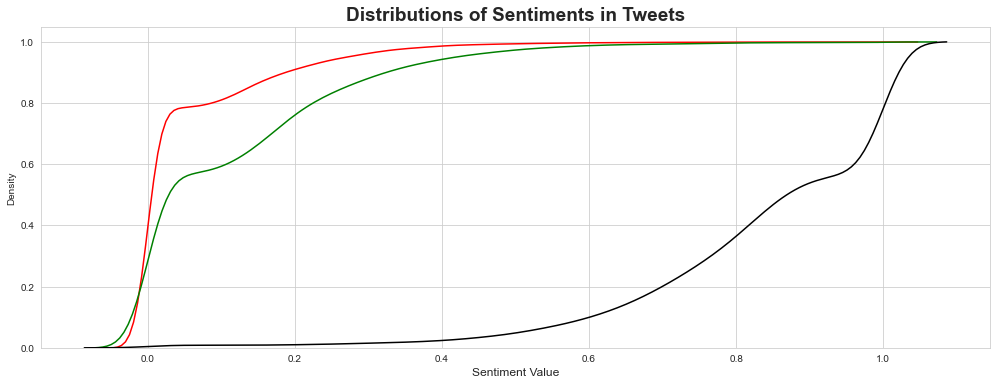

In [9]:
plt.subplot(2,1,2)
plt.title('Distributions of Sentiments in Tweets',fontsize=19,fontweight='bold')
sns.kdeplot(data['Negative Sentiment'],cumulative=True, color = 'red')
sns.kdeplot(data['Positive Sentiment'],cumulative=True, color = 'green')
sns.kdeplot(data['Neutral Sentiment'],cumulative=True, color = 'black')
plt.xlabel('Sentiment Value',fontsize=12)
plt.show()

- By EDA we can say that positive sentiments and negative sentiments are almost same but neutral sentiment give an off distribution

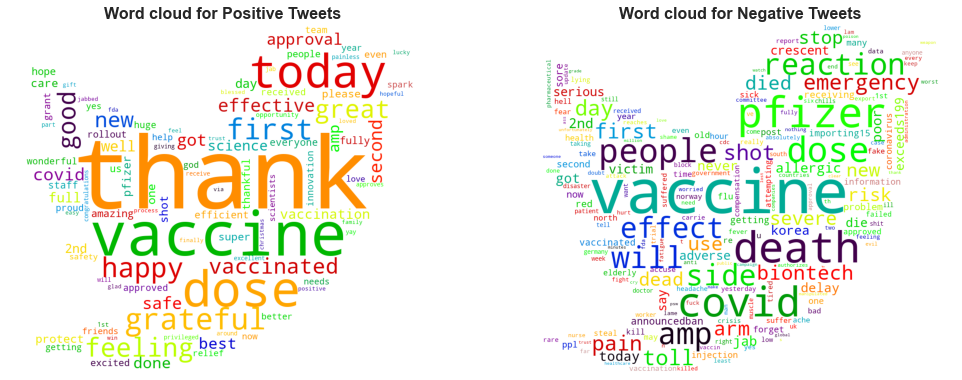

In [10]:
Most_Positive = data[data['Positive Sentiment'].between(0.4,1)]
Most_Negative = data[data['Negative Sentiment'].between(0.25,1)]

Most_Positive_text = ' '.join(Most_Positive.text)
Most_Negative_text = ' '.join(Most_Negative.text)

#Creating a twitter shaped word cloud
mask = np.array(Image.open('twitter.png'))

pwc = WordCloud(width=600,height=400,max_font_size=500,max_words=100,random_state=1,colormap = 'nipy_spectral',collocations = False, background_color='white', mask = mask).generate(Most_Positive_text)
nwc = WordCloud(width=600,height=400,collocations = False,random_state=1,colormap = 'nipy_spectral', background_color='white',mask=mask,).generate(Most_Negative_text)

plt.subplot(1,2,1)
plt.title('Word cloud for Positive Tweets',fontsize=16,fontweight='bold')
plt.imshow(pwc)
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Word cloud for Negative Tweets',fontsize=16,fontweight='bold')
plt.imshow(nwc)
plt.axis('off')

plt.show()

### Finding out 50 words in most Positive and Negative tweets

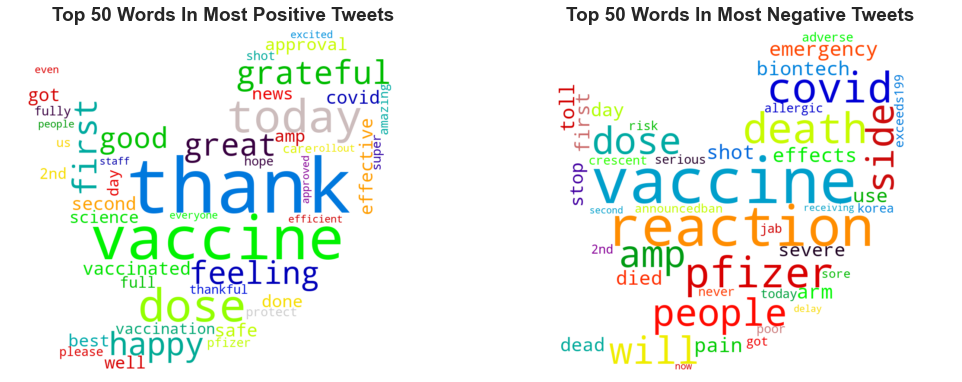

In [11]:
l_t = Most_Positive_text

w1_dict = dict()
for word in l_t.split():
    w= word.strip()
    if w in STOPWORDS:
        continue
    else:
        w1_dict[w] = w1_dict.get(w,0)+1
w1_dict = {k: v for k, v in sorted(w1_dict.items(), key=lambda item: item[1],reverse=True)}

l_t = Most_Negative_text
w2_dict = dict()
for word in l_t.split():
    w= word.strip()
    if w in STOPWORDS:
        continue
    else:
        w2_dict[w] = w2_dict.get(w,0)+1
w2_dict = {k: v for k, v in sorted(w2_dict.items(), key=lambda item: item[1],reverse=True)}

top_10_pos = list(w1_dict.keys())[:50]
top_10_neg = list(w2_dict.keys())[:50]


#Creating word cloud
plt.subplot(1,2,1)
w_c = WordCloud(width=600,height=400,collocations = False,colormap='nipy_spectral',random_state=2,background_color="white",mask =mask).generate(' '.join(top_10_pos))
plt.title('Top 50 Words In Most Positive Tweets',fontsize=19,fontweight='bold')
plt.imshow(w_c, interpolation="bilinear")
plt.axis('off')
plt.subplot(1,2,2)
w_c = WordCloud(width=600,height=400,collocations = False,colormap='nipy_spectral',random_state=6,background_color="white", mask = mask).generate(' '.join(top_10_neg))
plt.title('Top 50 Words In Most Negative Tweets',fontsize=19,fontweight='bold')
plt.imshow(w_c, interpolation="bilinear")
plt.axis('off')
plt.show()

In [12]:
#Creating a new dataframe for Topic Modeling
df = data
df_t =  df[['date','text']]
reindexed_data = df_t['text']
reindexed_data.index = df_t['date']
df_t.head()

,date,text
0,2020-12-20 06:06:44,same folks said daikon paste could treatcytoki...
1,2020-12-13 16:27:13,while the world has been on the wrong side of ...
2,2020-12-12 20:33:45,russian vaccine is created to last 2 4 years
3,2020-12-12 20:23:59,facts are immutable senator even when you re n...
4,2020-12-12 20:17:19,explain to me again why we needvaccine


In [13]:
#Coverting the document to array
docs =array(df_t['text'])

#Uding our preprocessing helper function on our document
docs = docs_preprocessor(docs)

#Create Biagram & Trigram Models 

bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
            
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.2)

#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(corpus[:1])

Number of unique tokens: 1286
Number of documents: 11020
[[(0, 1), (1, 1), (2, 1), (3, 1)]]


In [14]:
#Picking 15 topics 
num_topics = 15

# Making an index to word dictionary
temp = dictionary[0]  # only to "load" the dictionary.
id2word = dictionary.id2token

#Running LDA model
lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=500 , \
                       alpha='auto', eta='auto', \
                       iterations=400, num_topics=num_topics, \
                       passes=20 , eval_every= 1)
# Print the Keyword in the 5 topics
print(lda_model.print_topics())

[(0, '0.251*"dose" + 0.179*"first_dose" + 0.152*"first" + 0.099*"second_dose" + 0.073*"second" + 0.035*"time" + 0.028*"have_been" + 0.028*"receive" + 0.022*"this_morning" + 0.012*"down"'), (1, '0.127*"this" + 0.100*"with" + 0.093*"from" + 0.093*"that" + 0.072*"have" + 0.059*"will" + 0.033*"they" + 0.033*"thanks" + 0.029*"what" + 0.029*"about"'), (2, '0.282*"covid" + 0.128*"case" + 0.072*"vaccination" + 0.072*"done" + 0.056*"full_approval" + 0.047*"full" + 0.034*"grant_full" + 0.030*"grant" + 0.024*"well" + 0.020*"said"'), (3, '0.093*"dos" + 0.082*"more" + 0.055*"data" + 0.051*"lakh_dos" + 0.043*"than" + 0.036*"30th_consignment" + 0.032*"million_dos" + 0.029*"finally" + 0.025*"million" + 0.024*"gifted_will"'), (4, '0.209*"child" + 0.142*"child_aged" + 0.131*"aged" + 0.110*"people" + 0.045*"getting" + 0.040*"expected" + 0.032*"many" + 0.029*"approves" + 0.023*"being" + 0.022*"protect"'), (5, '0.124*"just" + 0.058*"last" + 0.056*"over" + 0.051*"infection" + 0.049*"back" + 0.040*"united" +

In [15]:
# Computing Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4704784680864808


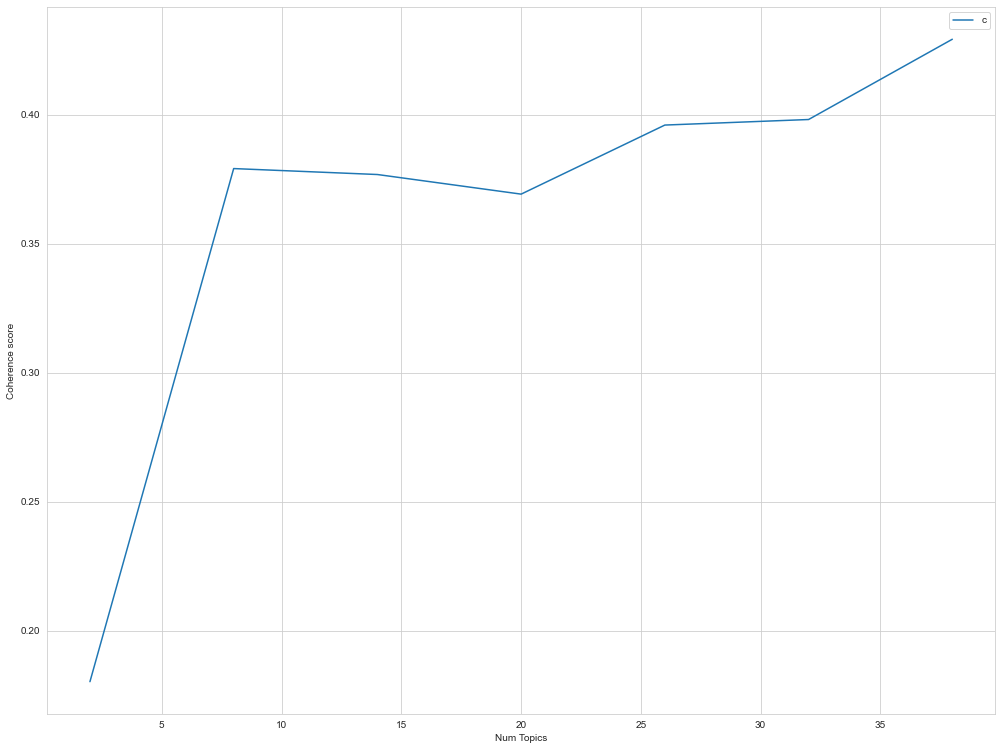

In [16]:
# Finding out the best k value
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=2, limit=40, step=6)
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Accoding to the graph the best k value is 38

In [17]:
#Calculating coherence score for 38 topics 
num_topics = 38

# Making an index to word dictionary
temp = dictionary[0]  # only to "load" the dictionary.
id2word = dictionary.id2token

#Running LDA model
lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=500 , \
                       alpha='auto', eta='auto', \
                       iterations=400, num_topics=num_topics, \
                       passes=20 , eval_every= 1)

# Computing Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5581511595521625


In [18]:
#Vectorizing the text
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_text_sample = reindexed_data.sample(n=10000, random_state=0, replace= True).values

print('Text before vectorization: {}'.format(small_text_sample[123]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('Text after vectorization: \n{}'.format(small_document_term_matrix[123]))

Text before vectorization: got my today seen by passionate and excellent staff thank you
Text after vectorization: 
  (0, 8890)	1
  (0, 3261)	1
  (0, 3901)	1
  (0, 8674)	1
  (0, 7810)	1
  (0, 6573)	1
  (0, 8248)	1


In [19]:
# Choosing number of Topics according to the K value from coherence graph
n_topics = 38

In [20]:
# Fitting LDA model
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

In [21]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [22]:
#Extracting top 10 words from eahch topic 

top_n_words_lda = get_top_n_words(10, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])
    

Topic 1:  grateful feeling vaccine dose today incredibly got amp happy covid
Topic 2:  jab cases vaccine health following hours got pfizer just vaccination
Topic 3:  38 second belgium day covid zavemtem vaccinem jobs lcc twice
Topic 4:  vaccine new approval covid variant fda pfizer allergic reactions 19
Topic 5:  vaccine use approved people pfizer emergency coronavirus know doses arrive
Topic 6:  vaccine today clinic walk effect help patients hall phase brave
Topic 7:  given vaccine tested positive really doses covid time residents 78
Topic 8:  headache vaccine make support dose thank national amp announced hrs
Topic 9:  just got vaccine ceo today dose weeks covid says shot
Topic 10:  data vaccine pfizer approves astrazeneca european medicines oxford biontech israel
Topic 11:  vaccine way making blame great wondering nation half vaccination amp
Topic 12:  vaccine dose vaccinated second giving record vaccines va jabbed black
Topic 13:  thanks vaccines days vaccine country hard immune go

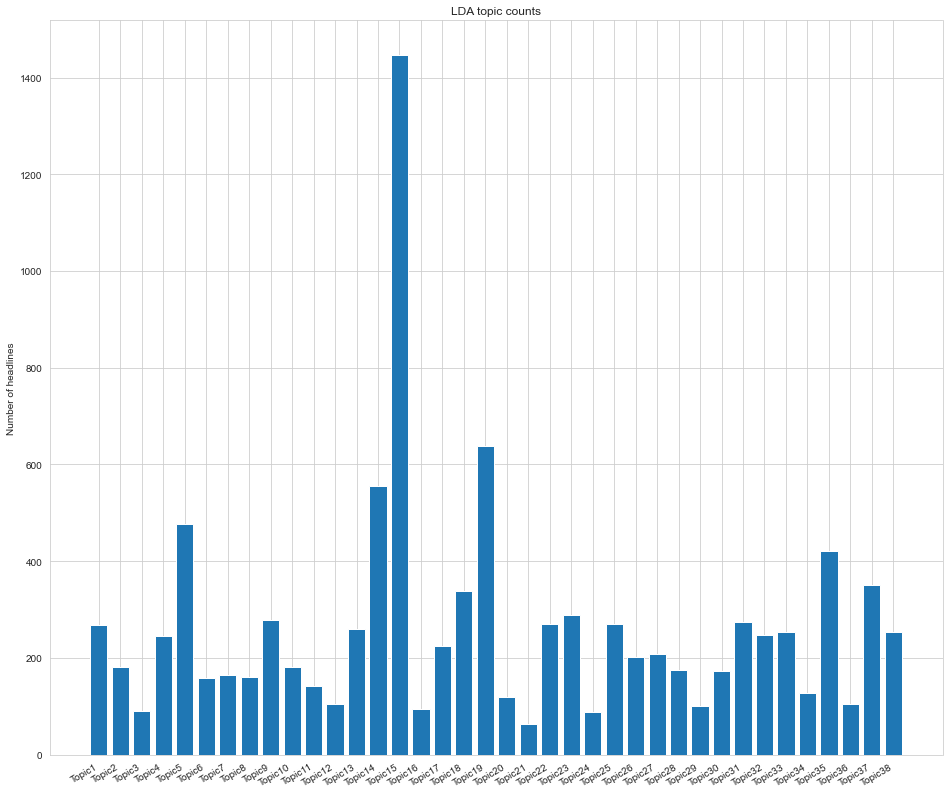

In [23]:
#Extracting Top 3 words
top_3_words = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic{}'.format(i+1) for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,15))
fig.autofmt_xdate()
ax.bar(lda_categories, lda_counts)
ax.set_xticks(lda_categories)
ax.set_xticklabels(labels)
ax.set_title('LDA topic counts')
ax.set_ylabel('Number of headlines')
plt.show()

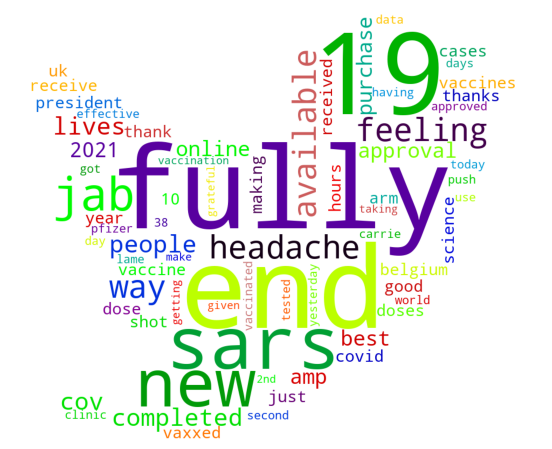

In [24]:
#Removing duplicate words
unq = dup(top_3_words)
words = set(unq )       
        
#Creating a Word cloud for top 3 words from each topic
wcloud(words)